<font size="8">Build an ANUGA Model (BAM) </font>

<font size="3">In this notebook, we will:

- set model configuration parameters

- download and preprocess elevation and landcover datasets

    
- Determine water body polygons


- Build the Digital Elevation Model



</font>

<font size="3">This could take some time, depending on model domain size and complexity of the water mask</font>


<font size=5 color='green'> If you are running in Google Colab, set the variable yes_colab = True.</font> <br>
<font size=5 color='blue'> If you are running on your own computer, set the variable yes_colab = False </font>


In [1]:
import os
import sys
from pathlib import Path
your_path = Path(os.getcwd() + '/')


In [2]:
yes_colab = False


<font size=6> Step #1a: Set working directory <br> </font>



<font size=5 color='green'> If you are running in Google Colab, when you run the next cell, a pop-up window will appear asking you to grant access to your Google Drive. You must approve or the notebook will not work. <font> <br>



In [3]:
if yes_colab:
    where_to_mount = '/content/drive/'
    from google.colab import drive
    drive.mount(where_to_mount, force_remount=True)
    mounted_drive = Path(where_to_mount) / 'MyDrive' 
    sys.path.append(str(mounted_drive / 'installations'))
    path_ancillary = mounted_drive / 'ancillary'
    Path(mounted_drive / 'installations').mkdir(parents=True, exist_ok=True)

else:
    mounted_drive = Path(os.path.abspath(os.path.join(your_path, os.pardir)))

print('Your working directory is %s' %(mounted_drive))
os.chdir(mounted_drive)



Your working directory is /Users/alchrist/Documents/GitHub/BAM


<font size=6> Step #1b: Install and import packages. <font> <br>

<font size=5 color='green'> If you are running in Google Colab, this cell should install all Python packages you need for each tutorial. </font> <br>
<font size=5 color='blue'> If you are running on your own computer, the packages were already installed when you installed the conda environment </font>


In [4]:
if yes_colab:
  if os.path.isdir(mounted_drive / 'BAM'):
    print('## Updating the local git repository \n')
    os.chdir(mounted_drive / 'BAM')
    #!git fsck --full
    # !git add -A 
    !git stash   
    !git pull
    # !rm -rf {mounted_drive/'BAM'}

  else:
    print('## Pulling the git repository with files for the tutorial\n')
    !git clone https://github.com/achri19/BAM.git


In [5]:
if yes_colab:
  print('\n## Installing the Python packages needed for these tutorials\n')
  try:
    import geopandas as gpd
  except:
    !/bin/bash $mounted_drive/BAM/notebooks/install_packages_colab_debug.sh


In [6]:
path_ancillary = mounted_drive / 'ancillary'
path_code = mounted_drive / 'scripts/'
path_templates = mounted_drive /  'templates/'
path_configs = mounted_drive / 'configs/'
sys.path.insert(1,str(path_code))


path_examples = mounted_drive / 'examples'
path_examples.mkdir(parents=True, exist_ok=True)

In [7]:
import pandas as pd
import shutil
from datetime import datetime
from string import Template
import fnmatch
import geopandas as gpd
import rasterio
from osgeo import gdal 
import matplotlib.pyplot as plt
import numpy as np
import rtree
from scipy import *


In [8]:
try:
  import pyTMD
except:
  !pip install pytmd

from main_tools import (build_directory,
                       get_extent_parameters,
                       setup_AOI_files, 
                       make_polygons,
                       make_channel_networks,
                       make_model_foundation, 
                       set_boundary_conditions, 
                       make_watermask,
                       more_opening)

## Google Earth Packages
import ee
from ee import batch

import zipfile



/Users/alchrist/Documents/GitHub/BAM/scripts/orinoco_tools.py:42: UserWarning: ShapelyDeprecationWarning
  warnings.warn('ShapelyDeprecationWarning')
/Users/alchrist/Documents/GitHub/BAM/scripts/orinoco_tools.py:43: UserWarning: UserWarning
  warnings.warn('UserWarning')


<font size=6> Step #1c: Choose to run the Demo or set up your own AOI. If running demo, unzip example files in Komo.zip <font> 




In [9]:
demo = False
if demo:
    with zipfile.ZipFile("komo_starter.zip", 'r') as zip_ref:
        zip_ref.extractall(path_examples)
    AOI = 'komo'
else:
    AOI = 'komo'

<font size=6, color ='black' > Step #2: Set the AOI and working directory  </font>


### AOI should match the name of the folder where files will be saved

### The extent shapefile must be provided and saved in the User_Defined_Files folder

In [10]:
Path((path_examples / AOI)).mkdir(parents=True, exist_ok=True)

skip = False
res = 10 #meters
print('\n')
print('Study area is ' + AOI)
print('Resolution of this setup is %sm' %(res))

working_path,folders = build_directory(path_examples, AOI)
working_path = Path(working_path)
print(working_path)





Study area is komo
Resolution of this setup is 10m



##############################################################################################
################################[Step 1][Build Directory]#####################################
##############################################################################################

##################### The working directory set as: 

/Users/alchrist/Documents/GitHub/BAM/examples/komo
 
##################### Folders are:
##################### 0 User_Defined_Files --> User shapefile of model domain and water mask
##################### 1 tmp --> For temporary files
##################### 3 Meshes --> Where we will build model meshes
##################### 4 DEMs --> Where we will build digital elevation models
##################### 5 Boundaries --> Where we will store boundary files
##################### 6 Simulations --> Where we will run simulations
##################### 7 Setup_Files/Setup_SHP --> Shapefiles for setup 
#########

<font size=6, color ='black' > Step #3: Use GEE to create a water mask for your AOI </font>


The output files will be generated and saved to your Google Drive. You must download them, manually select the best water mask and save it to the subfolder User_Defined_Files with the suffix *_finawatermask.tif*

In [11]:
run_gee = True

In [12]:
if run_gee:
    # Trigger the authentication flow.
    ee.Authenticate()

    # Initialize the library.
    ee.Initialize()

In [13]:
def maskS2clouds(image):
    qa = image.select('QA60');
    ##Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11
    ##Both flags should be set to zero, indicating clear conditions.
    cloudmask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))
    #cloudmask = qa.bitwiseAnd(cloudBitMask).eq(0)*(qa.bitwiseAnd(cirrusBitMask).eq(0))
    return image.updateMask(cloudmask)#.divide(10000)
    #return image.updateMask(qa.bitwiseAnd(cloudBitMask).eq(0)).updateMask(qa.bitwiseAnd(cirrusBitMask).eq(0)).divide(100000)  
def addNDWI(image):
  ndwi = image.normalizedDifference(['B8', 'B3']).rename('NDWI').toFloat();
  return image.addBands(ndwi)    
def addNDVI(image):
  #ndvi = image.normalizedDifference(['B8', 'B3']).rename('NDVI').toFloat();
  ndvi = (image.select(['B8']).subtract(image.select(['B3']))).divide(image.select(['B8']).add(image.select(['B3']))).rename('NDVI')
  return image.addBands(ndvi)
def addMNDWI(image):
  mndwi = image.normalizedDifference(['B3', 'B11']).rename('MNDWI');
  return image.addBands(mndwi)

In [14]:
extent_file  = folders[0] / ('%s_input.shp' %(AOI))


In [15]:
extent_gpd = gpd.read_file(extent_file)

if extent_gpd.crs == None:
    extent_gpd = extent_gpd.set_crs('EPSG:4326')
if extent_gpd.crs != 'EPSG:4326':
    print('reprojecting to EPSG')
    extent_gpd = extent_gpd.to_crs('EPSG:4326')

extent_gpd.geometry = extent_gpd.buffer(0.2,join_style = 2)
exterior_points = extent_gpd.geometry[0].exterior.coords[:]
exterior_points = list(map(list, exterior_points))
ee_poly = ee.Geometry.Polygon(coords=exterior_points)    



/var/folders/29/4c92_fhn3_g9d625mvc8mrth0000gq/T/ipykernel_12405/823930313.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  extent_gpd.geometry = extent_gpd.buffer(0.2,join_style = 2)


In [16]:
collectionS2 = ee.ImageCollection("COPERNICUS/S2")\
    .filter(ee.Filter.calendarRange(2019,2022,'year'))\
    .filter(ee.Filter.calendarRange(1,12,'month'))\
    .filterBounds(ee_poly)\
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 5))\
    .map(addNDWI)\
    .map(addMNDWI)\
    .map(addNDVI)\
    .map(maskS2clouds)  ;  
collectionVV = ee.ImageCollection('COPERNICUS/S1_GRD')\
    .filter(ee.Filter.eq('instrumentMode', 'IW'))\
    .filter(ee.Filter.calendarRange(2019,2022,'year'))\
    .filter(ee.Filter.calendarRange(1,12,'month'))\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
    .filterMetadata('resolution_meters', 'equals' , 10)\
    .filterBounds(ee_poly)\
    .select('VV');
collectionVH = ee.ImageCollection('COPERNICUS/S1_GRD')\
    .filter(ee.Filter.eq('instrumentMode', 'IW'))\
    .filter(ee.Filter.calendarRange(2019,2022,'year'))\
    .filter(ee.Filter.calendarRange(1,12,'month'))\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))\
    .filterMetadata('resolution_meters', 'equals' , 10)\
    .filterBounds(ee_poly)\
    .select('VH');

/Users/alchrist/anaconda3/envs/BAM_dev/lib/python3.10/site-packages/ee/deprecation.py:202: DeprecationWarning: 

Attention required for COPERNICUS/S2! You are using a deprecated asset.
To ensure continued functionality, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2

  warnings.warn(warning, category=DeprecationWarning)


In [17]:
## Process Sentinel-1 Data
VV_ref = collectionVV.max().focal_mean(30, 'circle', 'meters')
VH_ref = collectionVH.max().focal_mean(30, 'circle', 'meters')

# Process Sentinel-2 Data
S2_max = collectionS2.max()    
S2_min = collectionS2.min()
S2_mean = collectionS2.mean()    
ndwi_min = S2_min.select('NDWI')
ndvi_min = S2_min.select('NDVI')   
ndwi_max = S2_max.select('NDWI')
ndvi_max = S2_max.select('NDVI')   
ndwi_mean = S2_mean.select('NDWI')
ndvi_mean = S2_mean.select('NDVI')   



In [18]:
folder_on_drive = 'gee_' + AOI

In [19]:
if run_gee:

    ## NDWI max, VV, and VH composite
    bands = ['NDWI','VV','VH'];
    ref_composite = ee.Image.cat(ndwi_max.toFloat(),VV_ref.toFloat(),VH_ref.toFloat()).select(bands).clip(ee_poly);
    method = 'ndwimax_vvvhmax'
    print('Method is %s' %(method))

    ## Save composite
    # comp_out1 = batch.Export.image.toDrive(ref_composite, folder = folder_on_drive, description='%s_%s' %(AOI,method), fileFormat = 'GeoTiff',scale = 10,maxPixels=10000000000000 )
    # process = batch.Task.start(comp_out1)
    # print('Saved composite to Google Drive at GEE_drive_composites/%s_%s.tif' %(AOI,method))

    ## Unsupervised Clustering using S2 max, VV, and VH composite
    training = ref_composite.sample(region=ee_poly,scale=res,numPixels=500,tileScale = 16)
    classifier = ee.Clusterer.wekaKMeans(2).train(training,bands)
    water = ref_composite.select(bands).cluster(classifier);

    ## Save clusters
    mask_out1 = batch.Export.image.toDrive(water, region=ee_poly,folder = folder_on_drive, description='%s_%s_clustered' %(AOI,method),fileFormat = 'GeoTiff',scale = 10,maxPixels=10000000000000 )
    process = batch.Task.start(mask_out1)
    print('Saved clusters to Google Drive at %s/%s_%s' %(folder_on_drive,AOI,method))

else:
    print('Skipping')

Method is ndwimax_vvvhmax
Saved clusters to Google Drive at gee_komo/komo_ndwimax_vvvhmax


In [20]:
if run_gee:
    ## Save S2 mean VV and VH max
    bands = ['NDWI','VV','VH'];
    ref_composite = ee.Image.cat(ndwi_mean.toFloat(),VV_ref.toFloat(),VH_ref.toFloat()).select(bands).clip(ee_poly);
    method = 'ndwimean_vvvhmax'
    print('Method is %s' %(method))

    ## Save composite
    # comp_out2 = batch.Export.image.toDrive(ref_composite, folder = folder_on_drive, description='%s_%s' %(AOI,method), fileFormat = 'GeoTiff',scale = 10,maxPixels=10000000000000 )
    # process = batch.Task.start(comp_out2)
    # print('Saved composite to Google Drive at GEE_drive_composites/%s_%s.tif' %(AOI,method))

    ## Unsupervised Clustering using S2 max, VV, and VH composite
    training = ref_composite.sample(region=ee_poly,scale=res,numPixels=500,tileScale = 16)
    classifier = ee.Clusterer.wekaKMeans(2).train(training,bands)
    water = ref_composite.select(bands).cluster(classifier);

    ## Save clusters
    mask_out2 = batch.Export.image.toDrive(water, region=ee_poly,folder = folder_on_drive, description='%s_%s_clustered' %(AOI,method),fileFormat = 'GeoTiff',scale = 10,maxPixels=10000000000000 )
    process = batch.Task.start(mask_out2)
    print('Saved clusters to Google Drive at GEE_drive_masks/%s_%s' %(AOI,method))

else:
    print('Skipping')


Method is ndwimean_vvvhmax
Saved clusters to Google Drive at GEE_drive_masks/komo_ndwimean_vvvhmax


In [21]:
if run_gee: 
    ## Save NDVI and NDWI min
    bands = ['NDVI','NDWI'];
    ref_composite = ee.Image.cat(ndvi_min.toFloat(),ndwi_min.toFloat()).select(['NDWI','NDVI']).clip(ee_poly);      
    method = 'ndvimin_ndwimin'
    print('Method is %s' %(method))

    ## Save composite
    # comp_out3 = batch.Export.image.toDrive(ref_composite, folder = folder_on_drive, description='%s_%s' %(AOI,method), fileFormat = 'GeoTiff',scale = 10,maxPixels=10000000000000 )
    # process = batch.Task.start(comp_out3)
    # print('Saved composite to Google Drive at GEE_drive_composites/%s_%s.tif' %(AOI,method))

    ## Unsupervised Clustering using S2 max, VV, and VH composite
    training = ref_composite.sample(region=ee_poly,scale=res,numPixels=500,tileScale = 16)
    classifier = ee.Clusterer.wekaKMeans(2).train(training,bands)
    water = ref_composite.select(bands).cluster(classifier);

    ## Save clusters
    mask_out3 = batch.Export.image.toDrive(water, region=ee_poly,folder = folder_on_drive, description='%s_%s_clustered' %(AOI,method),fileFormat = 'GeoTiff',scale = 10,maxPixels=10000000000000 )
    process = batch.Task.start(mask_out3)
    print('Saved clusters to Google Drive at GEE_drive_masks/%s_%s' %(AOI,method))

else:
    print('Skipping')

Method is ndvimin_ndwimin
Saved clusters to Google Drive at GEE_drive_masks/komo_ndvimin_ndwimin


In [22]:
if run_gee:
    ## Save NDVI and NDWI max
    bands = ['NDVI','NDWI'];
    ref_composite = ee.Image.cat(ndvi_max.toFloat(),ndwi_max.toFloat()).select(['NDWI','NDVI']).clip(ee_poly);      
    method = 'ndvimax_ndwimax'
    print('Method is %s' %(method))

    ## Save composite
    #comp_out4 = batch.Export.image.toDrive(ref_composite, folder = folder_on_drive, description='%s_%s' %(AOI,method), fileFormat = 'GeoTiff',scale = 10,maxPixels=10000000000000 )
    #process = batch.Task.start(comp_out4)
    #print('Saved composite to Google Drive at GEE_drive_composites/%s_%s.tif' %(AOI,method))

    ## Unsupervised Clustering using S2 max, VV, and VH composite
    training = ref_composite.sample(region=ee_poly,scale=res,numPixels=500,tileScale = 16)
    classifier = ee.Clusterer.wekaKMeans(2).train(training,bands)
    water = ref_composite.select(bands).cluster(classifier);

    ## Save clusters
    mask_out4 = batch.Export.image.toDrive(water, region=ee_poly,folder = folder_on_drive, description='%s_%s_clustered' %(AOI,method),fileFormat = 'GeoTiff',scale = 10,maxPixels=10000000000000 )
    process = batch.Task.start(mask_out4)
    print('Saved clusters to Google Drive at GEE_drive_masks/%s_%s' %(AOI,method))

else:
    print('Skipping')


Method is ndvimax_ndwimax
Saved clusters to Google Drive at GEE_drive_masks/komo_ndvimax_ndwimax


### The output files will be generated and saved to your Google Drive. You must download them, manually select the best water mask and save it to the subfolder User_Defined_Files with the suffix *_finawatermask.tif*

In [23]:
final_watermasks = [os.path.join(dirpath,f)
    for dirpath,dirnames, files in os.walk(Path(path_examples) /AOI/'User_Defined_Files')
    for f in fnmatch.filter(files,'*_finalwatermask.tif')]

print(final_watermasks)


['/Users/alchrist/Documents/GitHub/BAM/examples/komo/User_Defined_Files/komo_ndvimax_ndwimax_clustered_finalwatermask.tif']


<font size='6' > Step #4: Configuration Parameters </font>


In [24]:

try:
    parameters = pd.read_csv(folders[0] / ('config_%s.csv' %(AOI)))
except:    
    parameters = pd.DataFrame()
    parameters['AOI'] = [AOI]

    #Method parameters:
    parameters['LandcoverMethod'] = 'WorldCover'
    parameters['LandElevMethod'] = 'GLO30'
    parameters['OceanElevMethod'] = 'GEBCO'
    parameters['LowerRiverElevMethod'] = 'plane'
    parameters['UpperRiverElevMethod'] = 'wdpower'
    parameters['WetlandElevMethod'] = 'constant_0.5'
    parameters['LakeElevMethod'] = 'constant_1'
    parameters['ManningLUT'] = 'default'
    parameters['WetlandClass'] = '90'

    #Coefficients for determining bathymetry:
    parameters['WD_POWERA_upper'] = '0.0606'
    parameters['WD_POWERB_upper'] = '0.7732'

    #Max thresholds:
    parameters['MaxOceanDepth'] = '-300'
    parameters['MaxNearshoreDepth'] = '-300'
    parameters['MaxRiverDepth'] = '-300'
    parameters['MaxRiverWidth'] = '756'

    parameters['resolution'] = res


If you didn't run the Download notebook, the following cells will won't work. Go back to that notebook and download ancillary data.

In [25]:
try:
    ref_10m = rasterio.open('%s_GEBCO_%s.tif' %(folders[8] / AOI,res))
except:
    ref_10m,parameters = get_extent_parameters(path_ancillary,AOI,folders,res,parameters)


Text(0.5, 1.0, 'GEBCO Bathymetry resampled to 10m resolution')

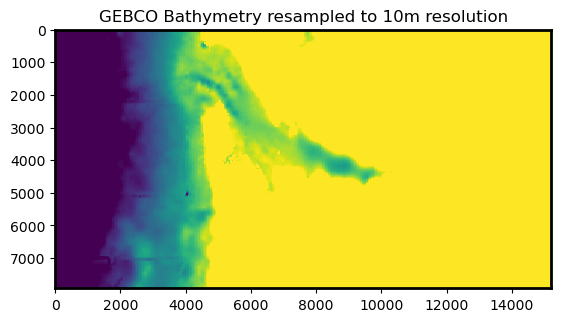

In [26]:
plt.imshow(ref_10m.read(1),vmin=-50,vmax=0)
plt.title('GEBCO Bathymetry resampled to 10m resolution')

<font size='5' color = 'red' > The parameters were saved to a configuration file, we open that here </font>


In [27]:
parameters = pd.read_csv(folders[2] / ('%s_Configuration.csv' %(AOI)))
print(parameters.iloc[0] )

Unnamed: 0.1                       0
Unnamed: 0                         0
AOI                             komo
LandcoverMethod           WorldCover
LandElevMethod                 GLO30
OceanElevMethod                GEBCO
LowerRiverElevMethod           plane
UpperRiverElevMethod         wdpower
WetlandElevMethod       constant_0.5
LakeElevMethod            constant_1
ManningLUT                   default
WetlandClass                      90
WD_POWERA_upper               0.0606
WD_POWERB_upper               0.7732
MaxOceanDepth                   -300
MaxNearshoreDepth               -300
MaxRiverDepth                   -300
MaxRiverWidth                    756
resolution                        10
ulx                           488516
lry                           -17969
lrx                           640556
uly                            61291
EPSG                           32232
Name: 0, dtype: object


<font size='6' > Step #4: Download datasets </font>
<br> Download GEBCO, GLO30, World Cover, and Global Mangrove Maps for the area</font>

In [28]:
ref = setup_AOI_files(your_path,
                    AOI,
                    folders,
                    res,
                    parameters)





##############################################################################################
#################################[Step 2][Setup_AOI_Files]####################################
##############################################################################################

##################### Reference raster is komo_GEBCO_10.tif
##################### This profile will be used for all future warping
##################### Resolution is 10m

[Step 2][Setup_AOI_Files][Compiling OCEAN elevation dataset] .......

##################### Ocean elevation set with:  GEBCO

[Step 2][Setup_AOI_Files][Compiling LAND elevation dataset] .......

##################### Land elevation set with: GLO30

[Step 2][Setup_AOI_Files][Compiling Landcover Classification Maps] .......

##################### Landcover types based on: WorldCover

[Step 2][Setup_AOI_Files][Loading Global Mangrove Watch ] .......



/Users/alchrist/anaconda3/envs/BAM_dev/lib/python3.10/site-packages/osgeo/gdal.py:287: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(



[Step 3A][Make_Watermask][Delineating wetland areas] ......


[Step 3A][Make_Watermask][Delineating agriculture areas] ......


[Step 2][Setup_AOI_Files] Finished .......



<font size='5' color = 'red' > The EPSG coordinate reference system must be is in UTM </font>


In [29]:
EPSG = parameters['EPSG'][0]
ulx = parameters['ulx'][0]
uly = parameters['uly'][0]
lrx = parameters['lrx'][0]
lry = parameters['lry'][0]


Text(0.5, 1.0, 'WorldCover Landcover Map')

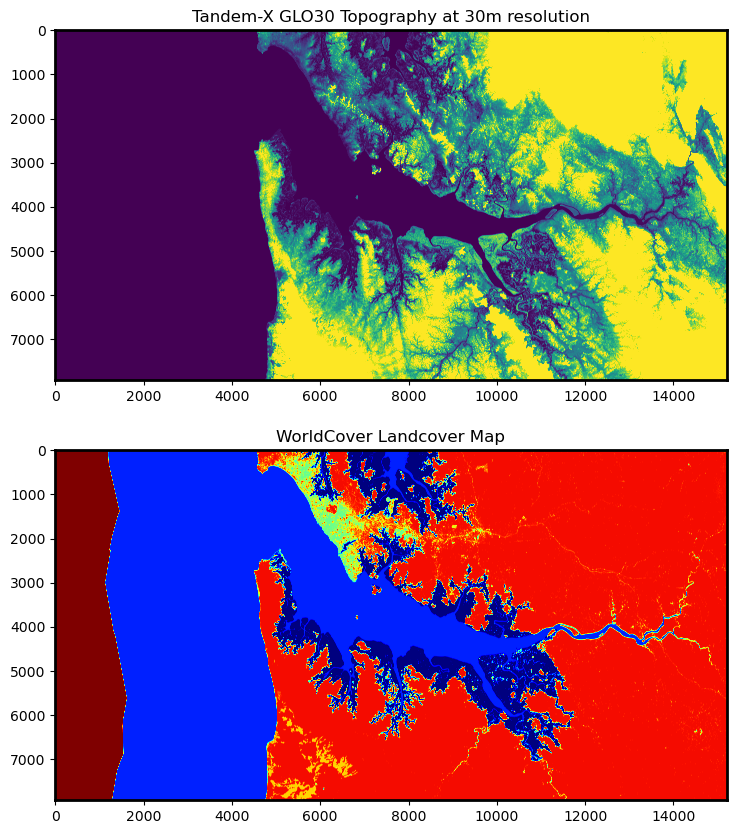

In [30]:
#ref = rasterio.open('%s/%s_GEBCO_%s.tif' %(folders[8],AOI,res))
glo30 = rasterio.open(folders[8] / ('%s_GLO30_topo_%s.tif' %(AOI,res)))
landcover = rasterio.open(folders[8] / ('%s_WorldCover_%s.tif' %(AOI,res)))

fig,[ax1,ax2] = plt.subplots(nrows=2,figsize=(10,10))
ax1.imshow(glo30.read(1),vmin=0,vmax=50,cmap = 'viridis')
ax1.set_title('Tandem-X GLO30 Topography at 30m resolution')

ax2.imshow(landcover.read(1),cmap='jet_r')
ax2.set_title('WorldCover Landcover Map')


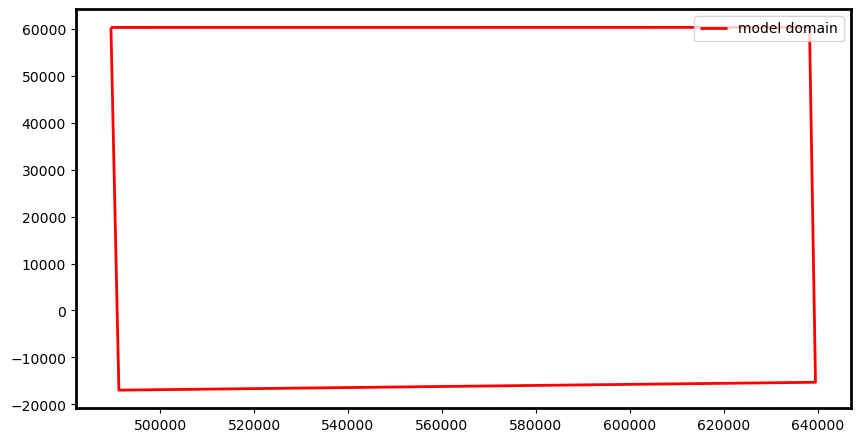

In [31]:
model_domain = gpd.read_file(folders[7] / ('%s_modeldomain.shp' %(AOI)))

fig,ax = plt.subplots(figsize=(10,10))
model_domain.geometry.boundary.plot(color=None,edgecolor='red',linewidth = 2,ax=ax,label = 'model domain') #Use your second dataframe

plt.legend()

<font size='6' > Step #4: Clean the water mask </font> <br>
Clean, filter, smooth the water mask you made in GEE</font>



In [32]:
watermaskname = make_watermask(path_ancillary, 
                               AOI,
                               folders,
                               parameters,
                               ref_10m,
                               True, 
                               False)
how_much_opening = 0 ## increase this to eroded clogged channels, too much erosion will lead to artificially wide channels
more_opening(AOI,folders,watermaskname,how_much_opening,ref_10m,parameters)


ERROR:fiona._env:/Users/alchrist/Documents/GitHub/BAM/examples/komo/User_Defined_Files/komo_SWOTPLD.shp: No such file or directory
ERROR:fiona._env:/Users/alchrist/Documents/GitHub/BAM/ancillary/SWOT_PLD.gdb/SWOT_PLD.shp: No such file or directory





##############################################################################################
#################################[Step 3a][Make_Watermask]####################################
##############################################################################################


[Step 2][Setup_AOI_Files][Compiling Water Masks] .......

##################### Google Earth Engine water mask file : komo_ndvimax_ndwimax_clustered_finalwatermask.tif

[Step 3A][Make_Watermask][Load Hydropolys] .......


[Step 3A][Make_Watermask][Load SWOT PLD lakes] .......

##################### Extracting SWOT PLD Lakes for the AOI
There are no lakes in the model domain

[Step 3A][Make_Watermask][Smoothing water and land masks] .......


[Step 3A][Make_Watermask][Start with the GEE watermask at 10m resolution] .......


[Step 3A][Make_Watermask][Removing wetland and agriculture areas from water mask] ......


[Step 3A][Make_Watermask][Determine whether 0 or 1 is water in GEE watermask] ......


[S

In [33]:
print(watermaskname)
if res != 10:
    os.system('gdalwarp -overwrite -tr %s %s %s %s '\
                      ' -te %s %s %s %s -srcnodata -9999 -dstnodata -9999 -co COMPRESS=DEFLATE -q'
                      %(res,res,folders[8]/ ("%s_watermask_10.tif " %(AOI)),folders[8] / ("%s_watermask_%s.tif" %(AOI,res)),ulx,lry,lrx,uly))
    os.system('gdalwarp -overwrite -tr %s %s %s %s '\
                      ' -te %s %s %s %s -srcnodata -9999 -dstnodata -9999 -co COMPRESS=DEFLATE -q'
                      %(res,res,folders[8] / ("%s_landmask_10.tif" %(AOI)),folders[8] / ("%s_landmask_%s.tif" %(AOI,res)),ulx,lry,lrx,uly))


komo_ndvimax_ndwimax_clustered_finalwatermask


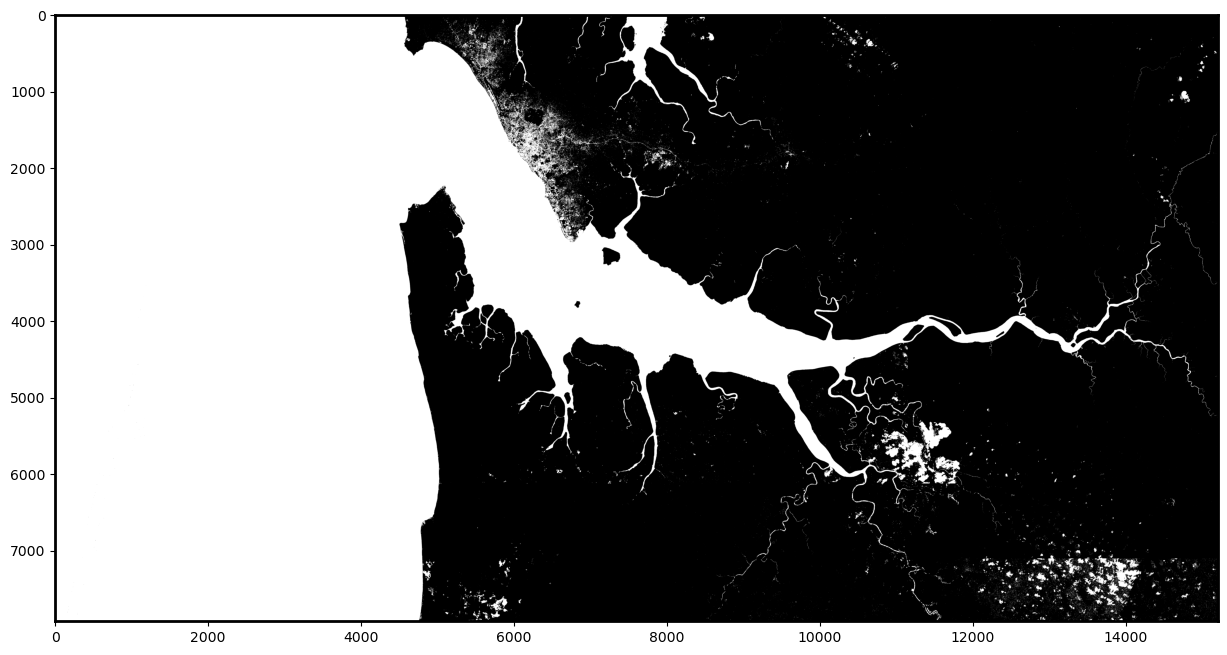

In [34]:
watermask = rasterio.open(folders[8] / ('%s_watermask_%s.tif' %(AOI,res))).read(1)

fig,ax1 = plt.subplots(nrows=1,figsize=(15,15))
ax1.imshow(watermask,'gray')


<font size='6' > Step #5: Make polygons of each land cover type <br> </font>
Ocean, lake, river, land


In [35]:
make_polygons(AOI,
            folders,
            parameters,
            ref,
            watermaskname,
            path_templates,
            os.path.isfile('%s_lands_%s.tif' %(folders[8]/AOI,res)))





##############################################################################################
################################[Step 4][Make_Polygons]######################################
##############################################################################################


[Step 4][Make_Polygons][Open land/water mask] .......

##################### Water delineated with komo_ndvimax_ndwimax_clustered_finalwatermask_10

[Step 4][Make_Polygons] SKIP.......



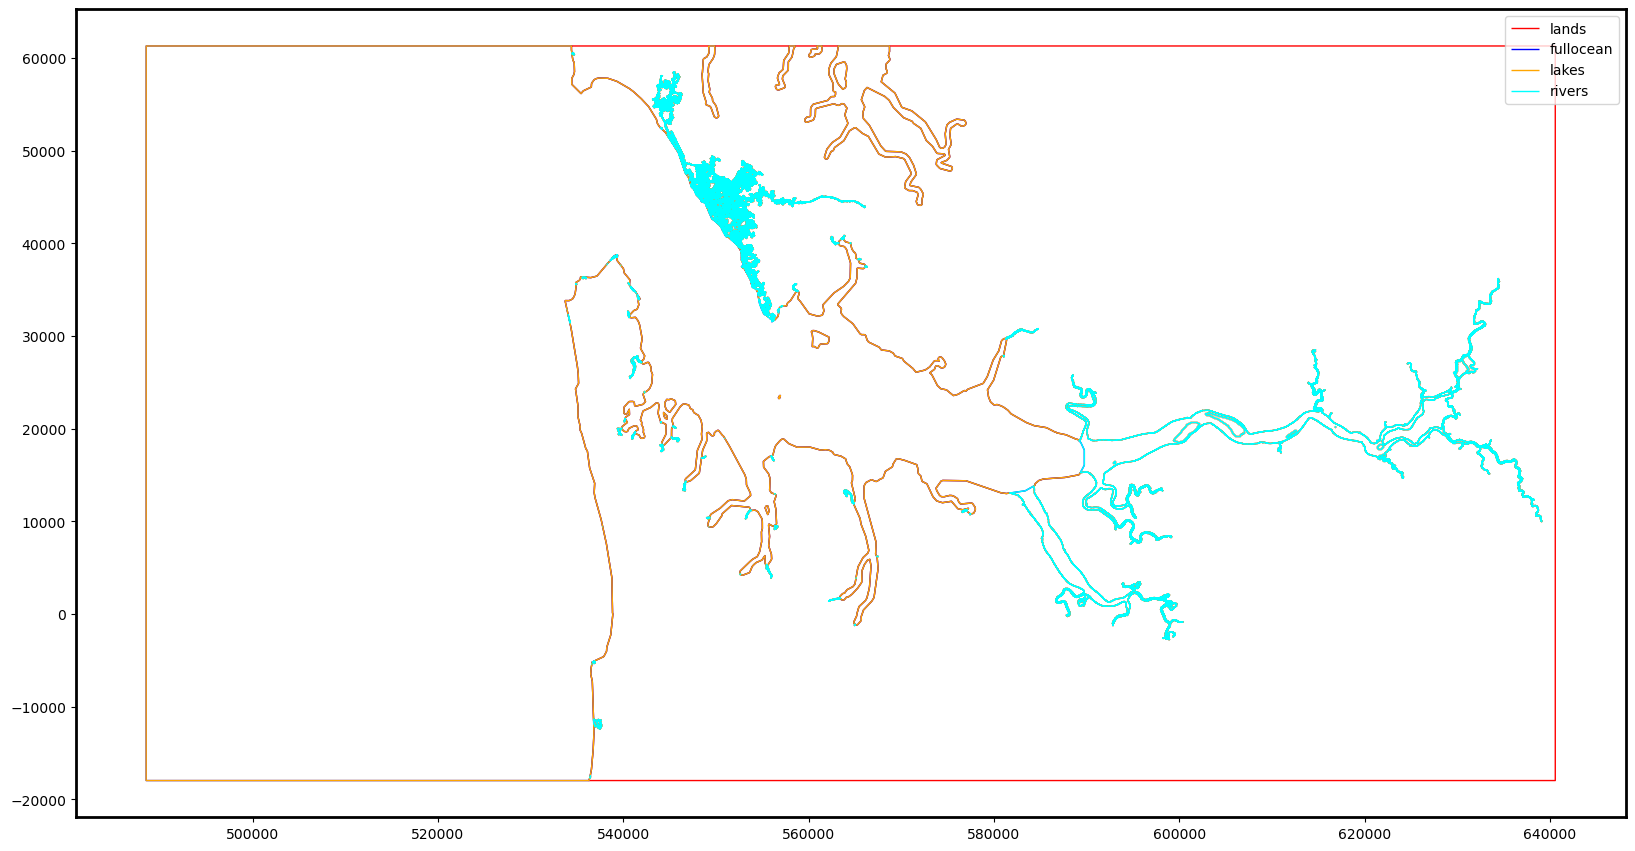

In [36]:
fix,ax = plt.subplots(figsize=(20,20))

colors = ['red','blue','orange','cyan','green']
polys = ['lands','fullocean','lakes','rivers']
i=0
for poly in polys:
    tmp = gpd.read_file([os.path.join(dirpath,f)
            for dirpath,dirnames, files in os.walk(folders[7])
            for f in fnmatch.filter(files,'*%s*.shp' %(poly))][0])
    tmp.geometry.boundary.plot(color=colors[i], edgecolor=colors[i],linewidth = 1,ax=ax,label = poly) #Use your second dataframe
    i=i+1
plt.legend()


<font size='6' > Step #6: Using Orinoco, get distance and width of the river networks</font>


In [37]:
segment_width = 20
pixel_step = int(round(segment_width/res))
try:
  distance = gdal.Open('%s_distance_%s.tif' %(folders[8] / AOI,res)).ReadAsArray()
  widths = gdal.Open('%s_widths_%sx%s.tif' %(folders[8] / AOI,res,pixel_step)).ReadAsArray()
except:
  distance,widths = make_channel_networks(folders,
                                      AOI,
                                      ref,
                                      parameters,
                                      pixel_step,False)


In [38]:
parameters['RiverOceanBoundary'] = 1200
parameters.to_csv(folders[2] / ('%s_Configuration.csv' %(AOI)))



<font size='6' > Step #7: Make the Digital Elevation Model </font>


In [39]:
elevation,elev_name = make_model_foundation(mounted_drive,
                                                parameters,
                                                AOI,
                                                folders,
                                                ref,
                                                distance,
                                                widths,
                                                watermask,pixel_step,mounted_drive)





##############################################################################################
###############################[Step 6][Make_Model_Foundation]################################
##############################################################################################


[Step 6][Make_Model_Foundation][Determine all methods for calculating elevation for each land/water type] .......

##################### Method for land = GLO30
##################### Method for ocean = GEBCO
##################### Method for lower river reaches = plane
##################### Method for upper river reaches = wdpower
##################### Method for lakes = constant_1
##################### Method for wetlands = constant_0.5
##################### Max Depth for Rivers = -300
##################### Max Depth for Oceans = -300
##################### Max Depth for Nearshore = -300
##################### Boundary between Upper and Lower river reaches =  1200m
Elevation_ocean-GEBCO_land-GLO30_above

/Users/alchrist/Documents/GitHub/BAM/scripts/main_tools.py:1634: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (oceanBoundaryDepth - riverBoundaryDepth)/(oceanBoundaryDistance-riverBoundaryDistance)


##################### River boundary: Distance = 1200m Depth = 10.1893310546875m 
##################### Ocean boundary: Distance = 1200m Depth = 1.6613861386138613m
##################### Lower river depth is determined with a linear relationship: Depth = -inf x Distance + inf based on linear relationship between width and depth using river mouth and upper river data points

[Step 6][Make_Model_Foundation][Building DEM][Building land topography] .....

##################### Land from /Users/alchrist/Documents/GitHub/BAM/examples/komo/Setup_Files/Setup_RSTkomo_topo.tif

[Step 6][Make_Model_Foundation][Building DEM][Building lake bathymetry] .....

##################### Lake Depth set with:  1.0m uniform

[Step 6][Make_Model_Foundation][Building DEM][Building wetland topography] .....

##################### Wetland elevation set with:  0.5m uniform

[Step 6][Make_Model_Foundation][Building DEM][Put it all together into final DEM] .....

##################### Elevation File: 
Elevation_oce

<font size=5 color='green'> We will use the elevation file in later notebooks. </font>

In [40]:
print(elev_name)


Elevation_ocean-GEBCO_land-GLO30_above1200m-wdpower_below1200m-plane_wetland-uni05m_lakes-uni1m_10


<font size='6' > Step #6: Clean up temporary files </font> <br>


In [41]:
cleanup = False 
if cleanup == True:
    print('Cleaning up temporary files')
    try:shutil.rmtree(folders[1])
    except:''


<font size=5 color='red'> Done building DEM and other ancillary files. Move on to the next notebook 3_GetBoundaries.ipynb </font>
